In [93]:
import os
import geopandas as gpd
import pandas as pd
%matplotlib inline
os.chdir("C:\\Users\\renan\\Desktop\\full_count_2010")

In [103]:
list(range(1, 100, 1))

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [126]:
data = pd.read_csv('segdata_full.csv')
data['X'] = np.array(list(range(1, 101, 1)))
gdf = gpd.read_file('dummy_lattice_map.shp')

In [127]:
data.head()

,Unnamed: 0,A1,A2,B1,B2,C1,C2,D1,D2,E1,E2,F1,F2,G1,G2,H1,H2,X
0,g1,0,100,0,100,0,100,0,100,0,100,0,100,0,100,0,100,1
1,g2,0,100,0,100,100,0,0,100,0,100,0,100,0,100,0,100,2
2,g3,0,100,0,100,0,100,0,100,50,50,0,100,0,100,0,100,3
3,g4,0,100,100,0,100,0,0,100,100,0,0,100,0,100,0,100,4
4,g5,0,100,100,0,0,100,50,50,100,0,0,100,0,100,0,100,5


In [128]:
gdf.head()

,X,geometry
0,1,"POLYGON ((0 9, 0 10, 1 10, 1 9, 0 9))"
1,2,"POLYGON ((1 9, 1 10, 2 10, 2 9, 1 9))"
2,3,"POLYGON ((2 9, 2 10, 3 10, 3 9, 2 9))"
3,4,"POLYGON ((3 9, 3 10, 4 10, 4 9, 3 9))"
4,5,"POLYGON ((4 9, 4 10, 5 10, 5 9, 4 9))"


In [129]:
df_mapa = gdf.merge(data, on='X')
df_mapa.head()

,X,geometry,Unnamed: 0,A1,A2,B1,B2,C1,C2,D1,D2,E1,E2,F1,F2,G1,G2,H1,H2
0,1,"POLYGON ((0 9, 0 10, 1 10, 1 9, 0 9))",g1,0,100,0,100,0,100,0,100,0,100,0,100,0,100,0,100
1,2,"POLYGON ((1 9, 1 10, 2 10, 2 9, 1 9))",g2,0,100,0,100,100,0,0,100,0,100,0,100,0,100,0,100
2,3,"POLYGON ((2 9, 2 10, 3 10, 3 9, 2 9))",g3,0,100,0,100,0,100,0,100,50,50,0,100,0,100,0,100
3,4,"POLYGON ((3 9, 3 10, 4 10, 4 9, 3 9))",g4,0,100,100,0,100,0,0,100,100,0,0,100,0,100,0,100
4,5,"POLYGON ((4 9, 4 10, 5 10, 5 9, 4 9))",g5,0,100,100,0,0,100,50,50,100,0,0,100,0,100,0,100


In [130]:
# Auxiliar Function
def _return_length_weighted_w(data):
    """
    Returns a PySAL weights object that the weights represent the length of the commom boudary of two areal units that share border.

    Parameters
    ----------

    data          : a geopandas DataFrame with a 'geometry' column.

    Notes
    -----
    Currently it's not making any projection.

    """
    
    if ('geometry' not in data.columns):    
        raise ValueError('The input data has to have a column named \'geometry\'')
    
    data['index'] = data.index
    w = libpysal.weights.Queen.from_dataframe(data, ids = data.index.tolist())
    
    adjlist = w.to_adjlist().merge(data[['index', 'geometry']], left_on='focal', right_on='index', how='left')\
              .drop('index', axis=1)\
              .merge(data[['index', 'geometry']], left_on='neighbor', right_on='index', 
                     how='left', suffixes=("_focal", "_neighbor"))\
              .drop('index', axis=1)
    
    # Transforming from pandas to geopandas
    adjlist = gpd.GeoDataFrame(adjlist, geometry='geometry_focal')
    adjlist['geometry_neighbor'] = gpd.GeoSeries(adjlist.geometry_neighbor)
    
    # Getting the shared boundaries
    adjlist['shared_boundary'] = adjlist.geometry_focal.intersection(adjlist.set_geometry('geometry_neighbor'))
    
    # Putting it back to a matrix
    adjlist['weight'] = adjlist.set_geometry('shared_boundary').length
    length_weighted_w = libpysal.weights.W.from_adjlist(adjlist[['focal', 'neighbor', 'weight']])
    
    return length_weighted_w

In [143]:
data['pi'] = data['E1'] / (data['E1'] + data['E2'])
data.head()

,Unnamed: 0,A1,A2,B1,B2,C1,C2,D1,D2,E1,E2,F1,F2,G1,G2,H1,H2,X,pi
0,g1,0,100,0,100,0,100,0,100,0,100,0,100,0,100,0,100,1,0.0
1,g2,0,100,0,100,100,0,0,100,0,100,0,100,0,100,0,100,2,0.0
2,g3,0,100,0,100,0,100,0,100,50,50,0,100,0,100,0,100,3,0.5
3,g4,0,100,100,0,100,0,0,100,100,0,0,100,0,100,0,100,4,1.0
4,g5,0,100,100,0,0,100,50,50,100,0,0,100,0,100,0,100,5,1.0


In [144]:
D = 1

In [145]:
dij = _return_length_weighted_w(df_mapa).full()[0]
wij = dij / np.sum(dij, axis = 1)

BSD = D - (1 / 2) * np.multiply(manhattan_distances(data[['pi']]), wij).sum()
BSD

-7.270833333333332

In [146]:
(1 / 2) * np.multiply(manhattan_distances(data[['pi']]), wij).sum()

8.270833333333332

In [147]:
wij

array([[0.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.33333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.        ,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.33333333,
        0.        ]])

In [148]:
cij = dij
# manhattan_distances used to compute absolute distances
num = np.multiply(manhattan_distances(data[['pi']]), cij).sum()
den = cij.sum()
SD = D - num / den
SD

0.8305555555555555

In [155]:
"""
Dissimilarity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Dissim']


def _dissim(data, group_pop_var, total_pop_var):
    """
    Calculation of Dissimilarity index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Dissimilarity Index

    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
        
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    data = data.assign(pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))
    
    D = (((data.total_pop_var * abs(data.pi - P)))/ (2 * T * P * (1 - P))).sum()
    
    return D


class Dissim:
    """
    Classic Dissimilarity Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Dissimilarity Index
        
    Examples
    --------
    In this example, we will calculate the degree of dissimilarity (D) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> dissim_index = Dissim(df, 'nhblk10', 'pop10')
    >>> dissim_index.statistic
    0.31565682496226544
    
    The interpretation of this value is that 31.57% of the non-hispanic black population would have to move to reach eveness in the Riverside County.
        
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var):

        self.statistic = _dissim(data, group_pop_var, total_pop_var)



In [365]:
"""
Spatial Dissimilarity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
import libpysal
from libpysal.weights import Queen
from sklearn.metrics.pairwise import manhattan_distances

__all__ = ['Spatial_Dissim']


def _spatial_dissim(data, group_pop_var, total_pop_var, w = None, std = False):
    """
    Calculation of Spatial Dissimilarity index

    Parameters
    ----------

    data          : a geopandas DataFrame with a 'geometry' column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    w             : W
                    A PySAL weights object. If not provided, Queen contiguity matrix is used.
                    
    std           : boolean
                    A condition for row standardisation of the weights matrices. If True, the values of cij in the formulas gets row standardized.
                    For the sake of comparison, the seg R package of Hong, Seong-Yun, David O'Sullivan, and Yukio Sadahiro. "Implementing spatial segregation measures in R." PloS one 9.11 (2014): e113767.
                    works by default with row standardization.
        

    Attributes
    ----------

    statistic : float
                Spatial Dissimilarity Index

    Notes
    -----
    Based on Morrill, R. L. (1991) "On the Measure of Geographic Segregation". Geography Research Forum.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
        
    if w is None:    
        w_object = Queen.from_dataframe(data)
    else:
        w_object = w
    
    if (not issubclass(type(w_object), libpysal.weights.W)):
        raise TypeError('w is not a PySAL weights object')
    
    if (type(std) is not bool):
        raise TypeError('std is not a boolean object')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    data = data.assign(pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))
    
    D = (((data.total_pop_var * abs(data.pi - P)))/ (2 * T * P * (1 - P))).sum()
    
    if not std:
        cij = w_object.full()[0]
    else:
        cij = w_object.full()[0]
        cij = cij / cij.sum(axis = 1).reshape((cij.shape[0], 1))

    # manhattan_distances used to compute absolute distances
    num = np.multiply(manhattan_distances(data[['pi']]), cij).sum()
    den = cij.sum()
    SD = D - num / den
    SD
    
    return SD


class Spatial_Dissim:
    """
    Calculation of Spatial Dissimilarity index

    Parameters
    ----------

    data          : a geopandas DataFrame with a 'geometry' column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    w             : W
                    A PySAL weights object. If not provided, Queen contiguity matrix is used.

    Attributes
    ----------

    statistic : float
                Spatial Dissimilarity Index
        
    Examples
    --------
    In this example, we will calculate the degree of spatial dissimilarity (D) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset. The neighborhood contiguity matrix is used.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
    
    Then, we read the Riverside map data using geopandas (the county id is 06065):
    
    >>> map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
    >>> map_gpd = gpd.read_file(map_url)
    
    It is necessary to harmonize the data type of the dataset and the geopandas in order to work the merging procedure.
    Later, we extract only the columns that will be used.
    
    >>> map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
    >>> gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
    >>> gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
    
    The value is estimated below.
    
    >>> spatial_dissim_index = Spatial_Dissim(gdf, 'nhblk10', 'pop10')
    >>> spatial_dissim_index.statistic
    0.2864885055405311
        
    To use different neighborhood matrices:
        
    >>> from libpysal.weights import Rook, KNN
    
    Assuming K-nearest neighbors with k = 4
    
    >>> knn = KNN.from_dataframe(gdf, k=4)
    >>> spatial_dissim_index = Spatial_Dissim(gdf, 'nhblk10', 'pop10', w = knn)
    >>> spatial_dissim_index.statistic
    0.28544347200877285
    
    Assuming Rook contiguity neighborhood
    
    >>> roo = Rook.from_dataframe(gdf)
    >>> spatial_dissim_index = Spatial_Dissim(gdf, 'nhblk10', 'pop10', w = roo)
    >>> spatial_dissim_index.statistic
    0.2866269198707091
            
    Notes
    -----
    Based on Morrill, R. L. (1991) "On the Measure of Geographic Segregation". Geography Research Forum.
    
    """

    def __init__(self, data, group_pop_var, total_pop_var, w = None, std = False):

        self.statistic = _spatial_dissim(data, group_pop_var, total_pop_var, w, std)

In [267]:
# Assymetric Spatial

In [361]:
gdf = gpd.read_file('SegP2.shp')
gdf['total'] = gdf['grp1'] + gdf['grp2']
gdf['total'] = gdf['grp1'] + gdf['grp2']

In [362]:
gdf.head()

,grp1,grp2,geometry,total
0,600.0,0.0,"POLYGON ((3.999973999900192 6.999974000199927,...",600.0
1,0.0,1900.0,"POLYGON ((2.999974000099996 7.999974000000066,...",1900.0
2,600.0,0.0,"POLYGON ((8.999973999800261 6.999974000199927,...",600.0
3,0.0,1900.0,"POLYGON ((7.999974000000066 7.999974000000066,...",1900.0
4,600.0,0.0,"POLYGON ((3.999973999900192 1.999974000299858,...",600.0


In [371]:
D = Dissim(gdf, 'grp1', 'total').statistic
D

1.0

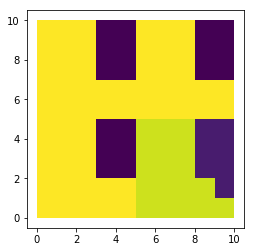

In [375]:
gdf.plot(column = 'total')

In [378]:
Dadj = Spatial_Dissim(gdf, 'grp1', 'total', std = False).statistic
Dadj

0.3571428571428571

In [357]:
data = gdf
cij = _return_length_weighted_w(data).full()[0]
cij = cij / cij.sum(axis = 1).reshape((cij.shape[0], 1))
cij

array([[0.        , 0.5       , 0.        , 0.5       , 0.        ],
       [0.27777778, 0.        , 0.44444444, 0.        , 0.27777778],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.        , 0.        , 0.        , 0.5       ],
       [0.        , 0.5       , 0.        , 0.5       , 0.        ]])

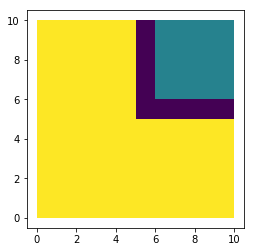

In [310]:
gdf.plot('total')

In [311]:
data.head()

,group_pop_var,grp2,geometry,total_pop_var,pi,index
0,0.0,2500.0,"POLYGON ((0.9999739996003996 4.99997399970033,...",2500.0,0.0,0
1,900.0,0.0,"POLYGON ((5.999974000399789 6.999974000199927,...",900.0,1.0,1
2,0.0,1600.0,"POLYGON ((6.999974000199927 5.999974000399789,...",1600.0,0.0,2
3,0.0,2500.0,POLYGON ((0.9999739996003996 -2.60001997389736...,2500.0,0.0,3
4,0.0,2500.0,POLYGON ((5.999974000399789 -2.600019973897361...,2500.0,0.0,4


In [312]:
data.rename(columns={'grp1': 'group_pop_var', 
                            'total': 'total_pop_var'})

,group_pop_var,grp2,geometry,total_pop_var,pi,index
0,0.0,2500.0,"POLYGON ((0.9999739996003996 4.99997399970033,...",2500.0,0.0,0
1,900.0,0.0,"POLYGON ((5.999974000399789 6.999974000199927,...",900.0,1.0,1
2,0.0,1600.0,"POLYGON ((6.999974000199927 5.999974000399789,...",1600.0,0.0,2
3,0.0,2500.0,POLYGON ((0.9999739996003996 -2.60001997389736...,2500.0,0.0,3
4,0.0,2500.0,POLYGON ((5.999974000399789 -2.600019973897361...,2500.0,0.0,4


In [313]:
data = data.rename(columns={'grp1': 'group_pop_var', 
                            'total': 'total_pop_var'})

In [314]:
#data = data.rename(columns={grp1: 'group_pop_var', 
#                           total: 'total_pop_var'})

if any(data.total_pop_var < data.group_pop_var):    
    raise ValueError('Group of interest population must equal or lower than the total population of the units.')

T = data.total_pop_var.sum()
P = data.group_pop_var.sum() / T

# If a unit has zero population, the group of interest frequency is zero
data = data.assign(pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))

In [315]:
data.head()

,group_pop_var,grp2,geometry,total_pop_var,pi,index
0,0.0,2500.0,"POLYGON ((0.9999739996003996 4.99997399970033,...",2500.0,0.0,0
1,900.0,0.0,"POLYGON ((5.999974000399789 6.999974000199927,...",900.0,1.0,1
2,0.0,1600.0,"POLYGON ((6.999974000199927 5.999974000399789,...",1600.0,0.0,2
3,0.0,2500.0,POLYGON ((0.9999739996003996 -2.60001997389736...,2500.0,0.0,3
4,0.0,2500.0,POLYGON ((5.999974000399789 -2.600019973897361...,2500.0,0.0,4


In [323]:
wij

array([[0.        , 0.5       , 0.        , 0.5       , 0.        ],
       [0.27777778, 0.        , 0.44444444, 0.        , 0.27777778],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.        , 0.        , 0.        , 0.5       ],
       [0.        , 0.5       , 0.        , 0.5       , 0.        ]])

In [316]:
 D - (1 / 2) * np.multiply(manhattan_distances(data[['pi']]), wij).sum()

-0.5

In [317]:
manhattan_distances(data[['pi']])

array([[0., 1., 0., 0., 0.],
       [1., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [318]:
np.multiply(manhattan_distances(data[['pi']]), wij).sum()

3.0

In [320]:
dij

array([[0., 5., 0., 5., 0.],
       [5., 0., 8., 0., 5.],
       [0., 8., 0., 0., 0.],
       [5., 0., 0., 0., 5.],
       [0., 5., 0., 5., 0.]])

In [319]:
dij = _return_length_weighted_w(data).full()[0]
wij = dij / np.sum(dij, axis = 1).reshape((dij.shape[0], 1))

BSD = D - (1 / 2) * np.multiply(manhattan_distances(data[['pi']]), wij).sum()
BSD

-0.5

In [325]:
cij = _return_length_weighted_w(data).full()[0]
#cij = cij / cij.sum(axis = 1).reshape((cij.shape[0], 1))

# manhattan_distances used to compute absolute distances
num = np.multiply(manhattan_distances(data[['pi']]), cij).sum()
den = cij.sum()
BSD_aux = D - num / den
BSD_aux

0.3571428571612103

In [390]:
"""
Boundary Spatial Dissimilarity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
#import libpysal
#from util import _return_length_weighted_w
from sklearn.metrics.pairwise import manhattan_distances

__all__ = ['Boundary_Spatial_Dissim']


def _boundary_spatial_dissim(data, group_pop_var, total_pop_var, std = False):
    """
    Calculation of Boundary Spatial Dissimilarity index

    Parameters
    ----------

    data          : a geopandas DataFrame with a 'geometry' column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    std           : boolean
                    A condition for row standardisation of the weights matrices. If True, the values of cij in the formulas gets row standardized.
                    For the sake of comparison, the seg R package of Hong, Seong-Yun, David O'Sullivan, and Yukio Sadahiro. "Implementing spatial segregation measures in R." PloS one 9.11 (2014): e113767.
                    works by default without row standardization. That is, directly with border length.
        

    Attributes
    ----------

    statistic : float
                Boundary Spatial Dissimilarity Index

    Notes
    -----
    The formula is based on Hong, Seong-Yun, David O'Sullivan, and Yukio Sadahiro. "Implementing spatial segregation measures in R." PloS one 9.11 (2014): e113767.
    
    Original paper by Wong, David WS. "Spatial indices of segregation." Urban studies 30.3 (1993): 559-572.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
    
    if (type(std) is not bool):
        raise TypeError('std is not a boolean object')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    data = data.assign(pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))
    
    D = (((data.total_pop_var * abs(data.pi - P)))/ (2 * T * P * (1 - P))).sum()
    
    if not std:
        cij = _return_length_weighted_w(data).full()[0]
    else:
        cij = _return_length_weighted_w(data).full()[0]
        cij = cij / cij.sum(axis = 1).reshape((cij.shape[0], 1))

    # manhattan_distances used to compute absolute distances
    #num = np.multiply(manhattan_distances(data[['pi']]), cij).sum()
    #den = cij.sum()
    #BSD = D - num / den
    BSD = D - (1/2) * np.multiply(manhattan_distances(data[['pi']]), cij).sum()
    BSD
    
    return BSD


class Boundary_Spatial_Dissim:
    """
    Calculation of Boundary Spatial Dissimilarity index

    Parameters
    ----------

    data          : a geopandas DataFrame with a 'geometry' column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    std           : boolean
                    A condition for row standardisation of the weights matrices. If True, the values of cij in the formulas gets row standardized.
                    For the sake of comparison, the seg R package of Hong, Seong-Yun, David O'Sullivan, and Yukio Sadahiro. "Implementing spatial segregation measures in R." PloS one 9.11 (2014): e113767.
                    works by default without row standardization. That is, directly with border length.
        

    Attributes
    ----------

    statistic : float
                Boundary Spatial Dissimilarity Index
        
    Examples
    --------
    In this example, we will calculate the degree of boundary spatial dissimilarity (D) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset. The neighborhood contiguity matrix is used.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
    
    Then, we read the Riverside map data using geopandas (the county id is 06065):
    
    >>> map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
    >>> map_gpd = gpd.read_file(map_url)
    
    It is necessary to harmonize the data type of the dataset and the geopandas in order to work the merging procedure.
    Later, we extract only the columns that will be used.
    
    >>> map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
    >>> gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
    >>> gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
    
    The value is estimated below.
    
    >>> boundary_spatial_dissim_index = Boundary_Spatial_Dissim(gdf, 'nhblk10', 'pop10')
    >>> boundary_spatial_dissim_index.statistic
    xxxxx
            
    Notes
    -----
    The formula is based on Hong, Seong-Yun, David O'Sullivan, and Yukio Sadahiro. "Implementing spatial segregation measures in R." PloS one 9.11 (2014): e113767.
    
    Original paper by Wong, David WS. "Spatial indices of segregation." Urban studies 30.3 (1993): 559-572.
    
    """

    def __init__(self, data, group_pop_var, total_pop_var, std = False):

        self.statistic = _boundary_spatial_dissim(data, group_pop_var, total_pop_var, std)

In [814]:
gdf = gpd.read_file('SegP1.shp')
gdf['total'] = gdf['grp1'] + gdf['grp2']
# In Wong (1993) they establish the neighbors differently
Spatial_Dissim(gdf, 'grp1', 'total', std = True).statistic

0.4999999999999999

In [815]:
Boundary_Spatial_Dissim(gdf, 'grp1', 'total', std = False).statistic

0.4999999999999999

In [816]:
Perimeter_Area_Ratio_Spatial_Dissim(gdf, 'grp1', 'total', std = True).statistic

0.7499999999999999

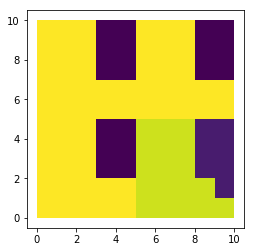

In [810]:
gdf.plot(column = 'total')

In [384]:
df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
map_gpd = gpd.read_file(map_url)
map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
boundary_spatial_dissim_index = Boundary_Spatial_Dissim(gdf, 'nhblk10', 'pop10')
boundary_spatial_dissim_index.statistic

0.28869903953453163

In [803]:
"""
Perimeter/Area Ratio Spatial Dissimilarity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
#import libpysal
from util import _return_length_weighted_w
from dissimilarity import _dissim
from sklearn.metrics.pairwise import manhattan_distances

__all__ = ['Perimeter_Area_Ratio_Spatial_Dissim']


def _perimeter_area_ratio_spatial_dissim(data, group_pop_var, total_pop_var, std = True):
    """
    Calculation of Perimeter/Area Ratio Spatial Dissimilarity index

    Parameters
    ----------

    data          : a geopandas DataFrame with a 'geometry' column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    std           : boolean
                    A condition for standardisation of the weights matrices. 
                    If True, the values of cij in the formulas gets standardized and the overall sum is 1.

    Attributes
    ----------

    statistic : float
                Perimeter/Area Ratio Spatial Dissimilarity Index

    Notes
    -----
    The formula is based on Hong, Seong-Yun, David O'Sullivan, and Yukio Sadahiro. "Implementing spatial segregation measures in R." PloS one 9.11 (2014): e113767.
    
    Original paper by Wong, David WS. "Spatial indices of segregation." Urban studies 30.3 (1993): 559-572.

    """
    if (type(std) is not bool):
        raise TypeError('std is not a boolean object')
    
    D = _dissim(data, group_pop_var, total_pop_var)
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    # If a unit has zero population, the group of interest frequency is zero
    data = data.assign(pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))

    if not std:
        cij = _return_length_weighted_w(data).full()[0]
    else:
        cij = _return_length_weighted_w(data).full()[0]
        cij = cij / cij.sum()
   
    peri = data.length
    ai   = data.area
    
    aux_sum = np.add(np.array(list((peri / ai))), np.array(list((peri / ai))).reshape((len(list((peri / ai))),1)))
    
    max_pa = max(peri / ai)
    
    num = np.multiply(np.multiply(manhattan_distances(data[['pi']]), cij), aux_sum).sum()
    den = 4 * max_pa
    
    PARD = D - (num / den)
    PARD
    
    return PARD


class Perimeter_Area_Ratio_Spatial_Dissim:
    """
    Calculation of Perimeter/Area Ratio Spatial Dissimilarity index

    Parameters
    ----------

    data          : a geopandas DataFrame with a 'geometry' column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    std           : boolean
                    A condition for standardisation of the weights matrices. 
                    If True, the values of cij in the formulas gets standardized and the overall sum is 1.
        
    Attributes
    ----------

    statistic : float
                Perimeter/Area Ratio Spatial Dissimilarity Index
        
    Examples
    --------
    In this example, we will calculate the degree of perimeter/area ratio spatial dissimilarity (PARD) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
    
    Then, we read the Riverside map data using geopandas (the county id is 06065):
    
    >>> map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
    >>> map_gpd = gpd.read_file(map_url)
    
    It is necessary to harmonize the data type of the dataset and the geopandas in order to work the merging procedure.
    Later, we extract only the columns that will be used.
    
    >>> map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
    >>> gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
    >>> gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
    
    The value is estimated below.
    
    >>> perimeter_area_ratio_spatial_dissim_index = Perimeter_Area_Ratio_Spatial_Dissim(gdf, 'nhblk10', 'pop10')
    >>> perimeter_area_ratio_spatial_dissim_index.statistic
    0.31260876347432687
            
    Notes
    -----
    The formula is based on Hong, Seong-Yun, David O'Sullivan, and Yukio Sadahiro. "Implementing spatial segregation measures in R." PloS one 9.11 (2014): e113767.
    
    Original paper by Wong, David WS. "Spatial indices of segregation." Urban studies 30.3 (1993): 559-572.
    
    """

    def __init__(self, data, group_pop_var, total_pop_var, std = True):

        self.statistic = _perimeter_area_ratio_spatial_dissim(data, group_pop_var, total_pop_var, std)

In [792]:
cij

array([[0.        , 0.5       , 0.        , 0.5       , 0.        ],
       [0.27777778, 0.        , 0.44444444, 0.        , 0.27777778],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.        , 0.        , 0.        , 0.5       ],
       [0.        , 0.5       , 0.        , 0.5       , 0.        ]])